In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


currencies = ['EURJPY=X', 'GBPJPY=X', 'USDJPY=X','GBPUSD=X','BTCUSD=X','ETHUSD=X','GBPEUR=X',\
             'GBPSGD=X','GBPSEK=X','GBPSAR=X','CADUSD=X','CADJPY=X','AUDUSD=X','NZDUSD=X',\
             'NZDGBP=X','NZDEUR=X','AUDGBP=X','AUDEUR=X',]
daily_currency_prices = YahooFinancials(currencies).get_historical_price_data(start,end,'daily')
temp_df = pd.DataFrame.from_dict(daily_currency_prices.values()).T

In [3]:
print('Importation des librairies...')
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from yahoofinancials import YahooFinancials
from sklearn.metrics import mean_squared_error
from math import sqrt
print('Librairies importées')

Importation des librairies...


Using TensorFlow backend.


Librairies importées


In [4]:
start = '2014-01-28'
end = '2019-05-22'

In [6]:
currencies = ['GBPUSD=X']
daily_currency_prices = YahooFinancials(currencies).get_historical_price_data(start,end,'daily')

In [7]:
temp_df = pd.DataFrame.from_dict(daily_currency_prices.values()).T

In [8]:
gbpusd = pd.DataFrame.from_dict(temp_df.iloc[4,0])

In [9]:
df = pd.DataFrame()
df['Date'] = gbpusd['formatted_date']
df['High'] = gbpusd['high']
df['Low'] = gbpusd['low']
df['Open'] = gbpusd['open']
df['Close'] = gbpusd['close']
#df['Volume'] = gbpusd['volume']
df['Adj Close'] = gbpusd['adjclose']

In [10]:
delta = round(df.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')

Période d'étude :  1386
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  1109  jours 
Bloc 2 : 277  jours


In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [11]:
dataset = df.copy()
dataset = dataset.drop(dataset[['Close','Date']],axis=1)
dataset.rename(columns={'Adj Close':'Close'}, inplace=True)
dataset.fillna(dataset.mean(), inplace=True)

In [14]:
dataset.isnull().sum(),type(dataset)

(High     0
 Low      0
 Open     0
 Close    0
 dtype: int64, pandas.core.frame.DataFrame)

In [15]:
dataset.describe()

,High,Low,Open,Close
count,1386.000000,1386.000000,1386.000000,1386.000000
mean,1.423967,1.414214,1.419251,1.419276
std,0.142121,0.142653,0.142418,0.142415
min,1.208751,1.199515,1.203746,1.203935
25%,1.304087,1.295572,1.300834,1.300623
50%,1.392002,1.380682,1.387213,1.387059
75%,1.543639,1.533178,1.536860,1.536913
max,1.718715,1.714237,1.716237,1.716090


In [12]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [13]:
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 

In [14]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [15]:
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [16]:
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 

In [29]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 

In [19]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model
 

In [20]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 

In [21]:
# load dataset
seriesX = dataset.iloc[:,2]
seriesy = dataset.iloc[:,3]

In [22]:
# transform data to be stationary
raw_valuesX = seriesX.values
diff_valuesX = difference(raw_valuesX, 1)

raw_valuesy = seriesy.values
diff_valuesy = difference(raw_valuesy, 1)

In [23]:
 
# transform data to be supervised learning
supervisedX = timeseries_to_supervised(diff_valuesX, 1)
supervised_valuesX = supervisedX.values

supervisedy = timeseries_to_supervised(diff_valuesy, 1)
supervised_valuesy = supervisedy.values

In [24]:
# split data into train and test-sets
train = supervised_valuesX[0:bloc1]

test = supervised_valuesy[bloc1:]
 

In [25]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 

In [26]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)

W0524 08:09:46.573900 4581205440 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0524 08:09:46.608986 4581205440 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0524 08:09:46.622517 4581205440 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0524 08:09:46.903076 4581205440 deprecation_wrapper.py:119] From /Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/keras/optimizers.py:79

Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0069
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0068
Epoch 1/1
1109/1109 [==============================] - 2s 1ms/step - loss: 0.0068
Epoch 1/1
1109/1109 [==============================] - 2s 1ms/step - loss: 0.0068
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0067
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 1/1
1109/1109 [==============================] - 2s 1ms/step - loss: 0.0066
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 1/1
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0066
Epoch 1/1
1109/1

In [27]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1) 

array([[-0.06823148],
       [-0.01442057],
       [ 0.00343522],
       ...,
       [ 0.02651988],
       [ 0.01120204],
       [ 0.02378719]], dtype=float32)

In [47]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_valuesX, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	actual = raw_valuesy[len(train) + i + 1]
	print('Period=%d, Predicted=%f, Actual=%f' % (i+1, yhat, actual))
 

Period=1, Predicted=1.376396, Actual=1.377221
Period=2, Predicted=1.380056, Actual=1.360933
Period=3, Predicted=1.358846, Actual=1.357386
Period=4, Predicted=1.360445, Actual=1.357239
Period=5, Predicted=1.358096, Actual=1.353198
Period=6, Predicted=1.354327, Actual=1.357036
Period=7, Predicted=1.358449, Actual=1.355344
Period=8, Predicted=1.355893, Actual=1.354463
Period=9, Predicted=1.355809, Actual=1.352338
Period=10, Predicted=1.353311, Actual=1.355381
Period=11, Predicted=1.356325, Actual=1.356245
Period=12, Predicted=1.356804, Actual=1.350020
Period=13, Predicted=1.350630, Actual=1.354830
Period=14, Predicted=1.356638, Actual=1.351534
Period=15, Predicted=1.351443, Actual=1.347709
Period=16, Predicted=1.348712, Actual=1.343183
Period=17, Predicted=1.343970, Actual=1.344104
Period=18, Predicted=1.346005, Actual=1.337131
Period=19, Predicted=1.337295, Actual=1.338348
Period=20, Predicted=1.340300, Actual=1.330902
Period=21, Predicted=1.330711, Actual=1.331558
Period=22, Predicted=1

Test RMSE: 0.007


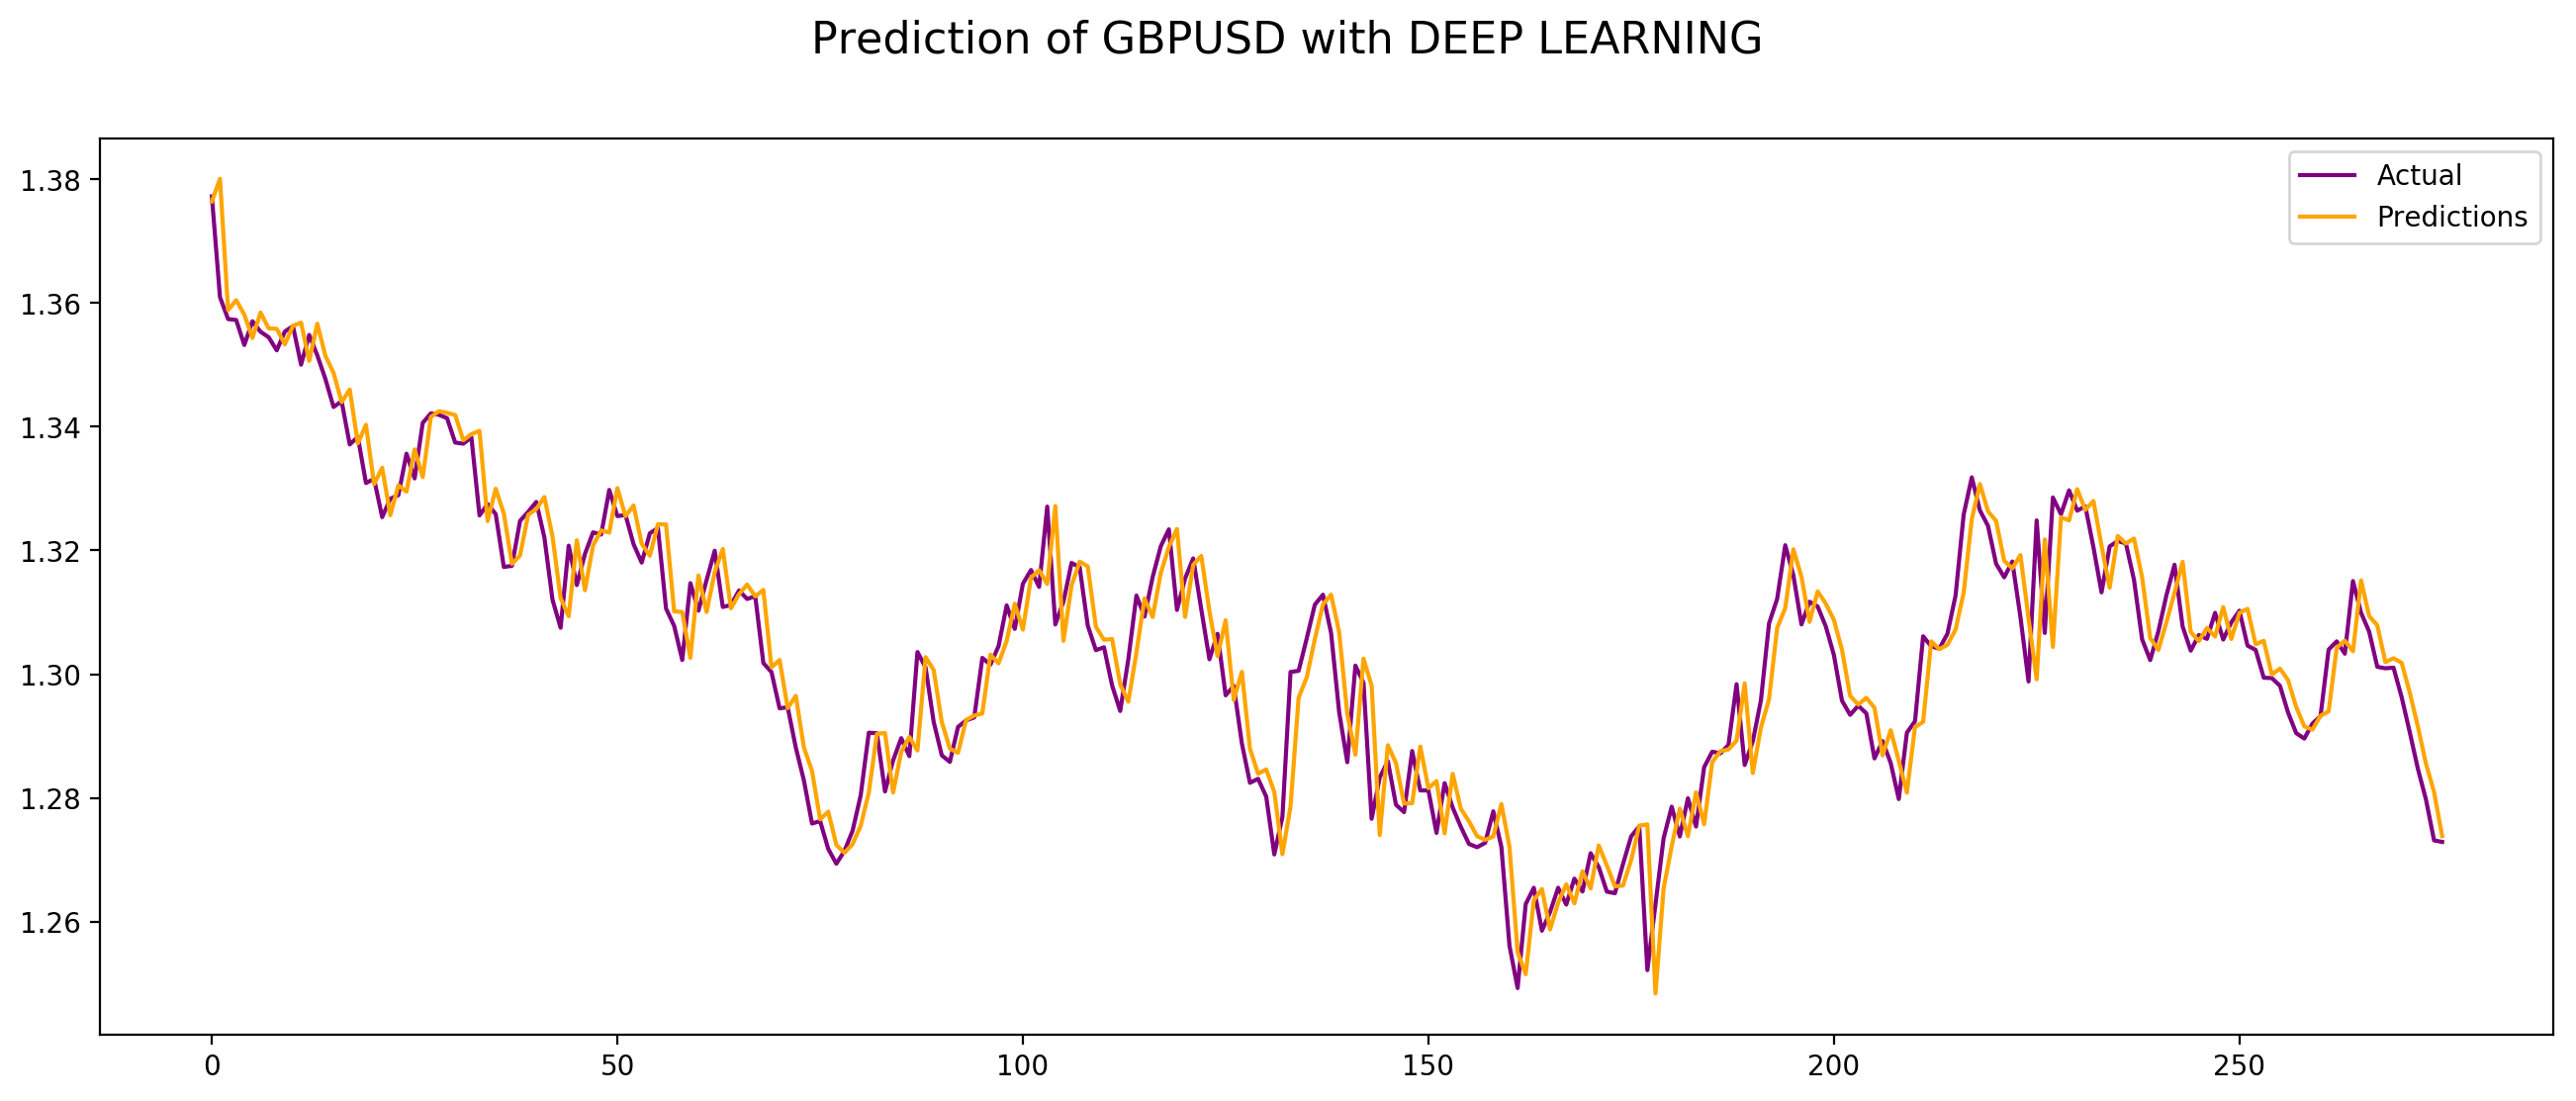

In [48]:
# report performance
rmse = sqrt(mean_squared_error(raw_valuesX[-len(predictions):], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(16,6),dpi=200)
plt.suptitle('Prediction of GBPUSD with DEEP LEARNING',fontsize=16)
plt.plot(raw_valuesy[-len(predictions):],label='Actual',color='purple')
plt.plot(predictions, color='orange',label='Predictions')
plt.legend()
plt.show()

In [42]:
len(raw_valuesX),len(predictions),bloc1,1386-1109-1

(1386, 276, 1109, 276)